# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
import json

sns.set_style("darkgrid")

sys.path.append('../src')

from RFClassifier import RFClassifier
from RFTuner import RFTuner
from DiskIO import DiskIO

# Baseline Random Forest Classifier

In [2]:
rf = RFClassifier()
rf.train()

Classification Report:
Accuracy: 98.12%
Recall: 97.42%
Specificity: 99.6%
PPV: 98.1%
NPV: 99.61%
F1: 97.74%


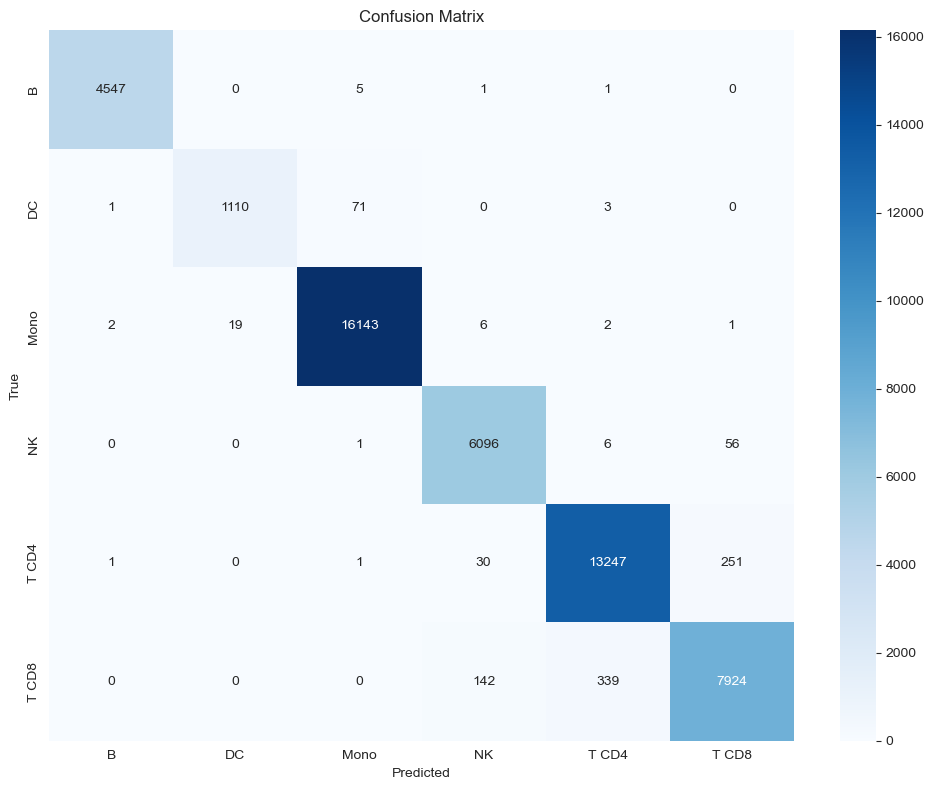

In [3]:
# Unpack the evaluation results
report, cm, stats = rf.evaluate()

print("Classification Report:")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
rf.plot_confusion_matrix(cm)

The model performs strongly overall, with most predictions falling along the diagonal. However, some minor confusion is observed between closely related T cell populations — e.g., CD4 vs. CD8 — which is expected due to their transcriptional similarity. Monocytes, B cells, and NK cells are classified with high confidence and minimal cross-contamination.

In [4]:
# Remove 'accuracy' because it's not a dict
accuracy = report.pop('accuracy', None)

# Convert to DataFrame
df_report = pd.DataFrame(report).T  # Transpose to have labels as rows

# Round float values
df_report = df_report.round(3)

# Add accuracy if present
if accuracy is not None:
    df_report.loc['accuracy'] = [None] * (df_report.shape[1] - 1) + [round(accuracy, 3)]

df_report

,precision,recall,f1-score,support
B,0.999,0.998,0.999,4554.000
DC,0.983,0.937,0.959,1185.000
Mono,0.995,0.998,0.997,16173.000
NK,0.971,0.990,0.981,6159.000
T CD4,0.974,0.979,0.977,13530.000
T CD8,0.963,0.943,0.953,8405.000
macro avg,0.981,0.974,0.977,50006.000
weighted avg,0.981,0.981,0.981,50006.000
accuracy,NaN,NaN,NaN,0.981


In [5]:
rf.save_model(suffix='baseline')
rf.save_label_encoder()

# Tuning - Nested CV

In [6]:
tuner = RFTuner()
tuner.tune_hyperparameters()

[I 2025-07-04 18:23:15,905] A new study created in memory with name: no-name-69abde8e-cc04-4956-a4c2-eb66c651398e
[I 2025-07-04 18:24:55,622] Trial 0 finished with value: 0.9565744509545131 and parameters: {'n_estimators': 238, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.9565744509545131.
[I 2025-07-04 18:26:03,180] Trial 1 finished with value: 0.9372046449180024 and parameters: {'n_estimators': 234, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.9565744509545131.
[I 2025-07-04 18:26:07,862] Trial 2 finished with value: 0.9447235725346796 and parameters: {'n_estimators': 136, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.9565744509545131.
[I 2025-07-04 18:26:12,254] Trial 3 finished with value: 0.9557714194620807 

[Nested CV] Outer F1 Scores: [0.9805694703837505, 0.9782078814877492, 0.9820706490794135, 0.9811246187934776, 0.9817813497954893]
[Nested CV] Median Outer F1 Score: 0.9811
[Nested CV] 95% CI for median F1: [0.9802, 0.9840]
[Nested CV] Standard Error of Median (approx): 0.0007


In [7]:
# Print best parameters
print("Best Parameters Found:")
print(tuner.best_params)

Best Parameters Found:
{'n_estimators': 268, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}


In [8]:
# Save best parameters to a JSON file to avoid running the tuning again
with open("../models/rf_best_params.json", "w") as f:
    json.dump(tuner.best_params, f, indent=4)

In [3]:
tuner = RFTuner()

In [11]:
# Load best parameters from JSON file
with open("../models/rf_best_params.json", "r") as f:
    best_params = json.load(f)

# Train and evaluate using internal 67/33 split
tuner.best_params = best_params
tuner.train_internal_split()

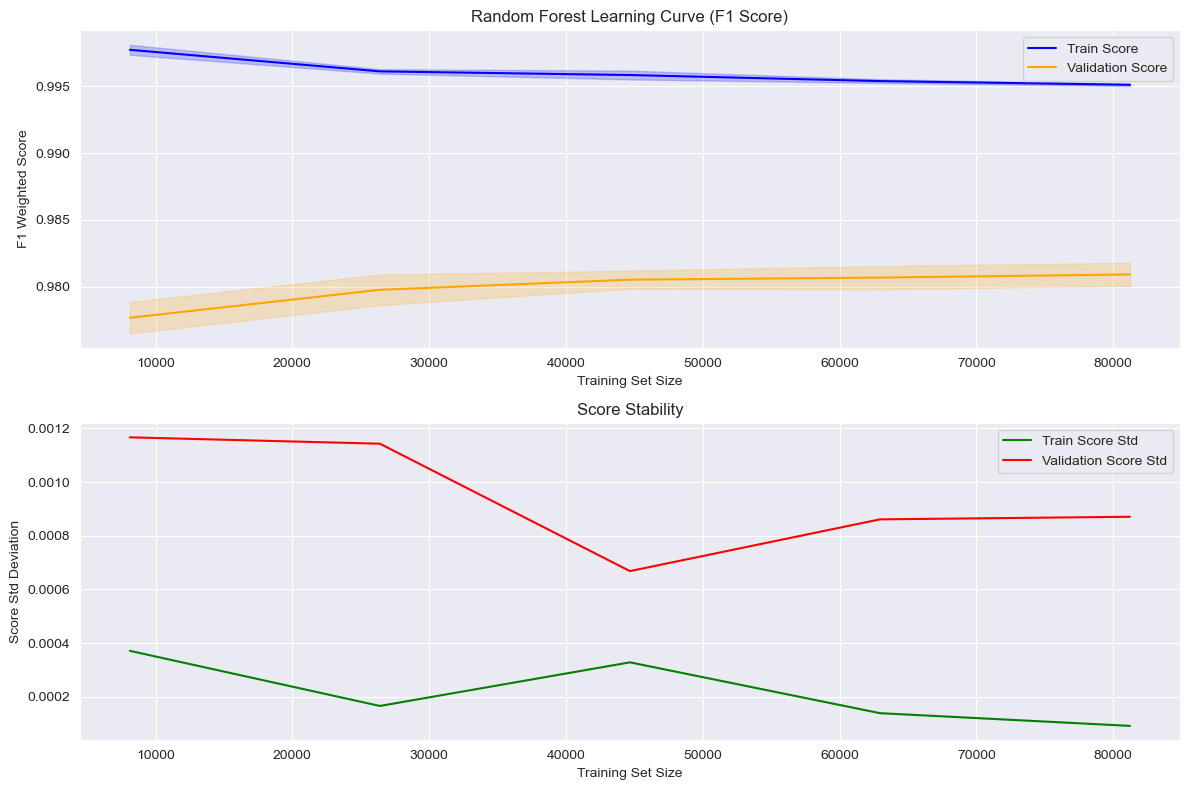

In [12]:
# Plot learning curve
tuner.plot_learning_curve()

We observe that:

- The training F1 score remains consistently high (~0.995) across all training sizes, indicating the model has high capacity and fits the training data well.
- The validation F1 score improves steadily as more training data is introduced, eventually plateauing around 0.980. This confirms the benefit of adding data for generalization.
- Importantly, validation score variance (red) drops significantly between 30k–50k samples, stabilizing at larger sizes. This suggests that the model’s performance becomes more reliable as more data is used.
- The relatively low standard deviation in training scores (green) indicates consistent model performance across splits, with minimal overfitting fluctuations.

Overall, the learning curve suggests that the model benefits from large training sets, and maintains stable generalization as the dataset grows.

In [13]:
# Train on full Hao datasets and save final model
tuner.train_and_save_final_model_on_full_data(suffix='final')

In [4]:
# Evaluate on external data (Kotliarov dataset)
report, cm, stats = tuner.evaluate_on_external_testset("../data/kotliarov.csv", suffix='final')

In [5]:
# Print results

# Remove 'accuracy' because it's not a dict
accuracy = report.pop('accuracy', None)

# Convert to DataFrame
df_report = pd.DataFrame(report).T  # Transpose to have labels as rows

# Round float values
df_report = df_report.round(3)

# Add accuracy if present
if accuracy is not None:
    df_report.loc['accuracy'] = [None] * (df_report.shape[1] - 1) + [round(accuracy, 3)]

df_report

,precision,recall,f1-score,support
B,0.999,0.983,0.991,5828.000
DC,0.966,0.868,0.914,646.000
Mono,0.980,0.989,0.984,7851.000
NK,0.926,0.963,0.944,4722.000
T CD4,0.898,0.976,0.935,20119.000
T CD8,0.950,0.769,0.850,9780.000
macro avg,0.953,0.925,0.936,48946.000
weighted avg,0.937,0.935,0.933,48946.000
accuracy,NaN,NaN,NaN,0.935


Tuned Model - Classification Report:
Accuracy: 93.48%
Recall: 92.47%
Specificity: 98.32%
PPV: 95.28%
NPV: 98.62%
F1: 93.64%


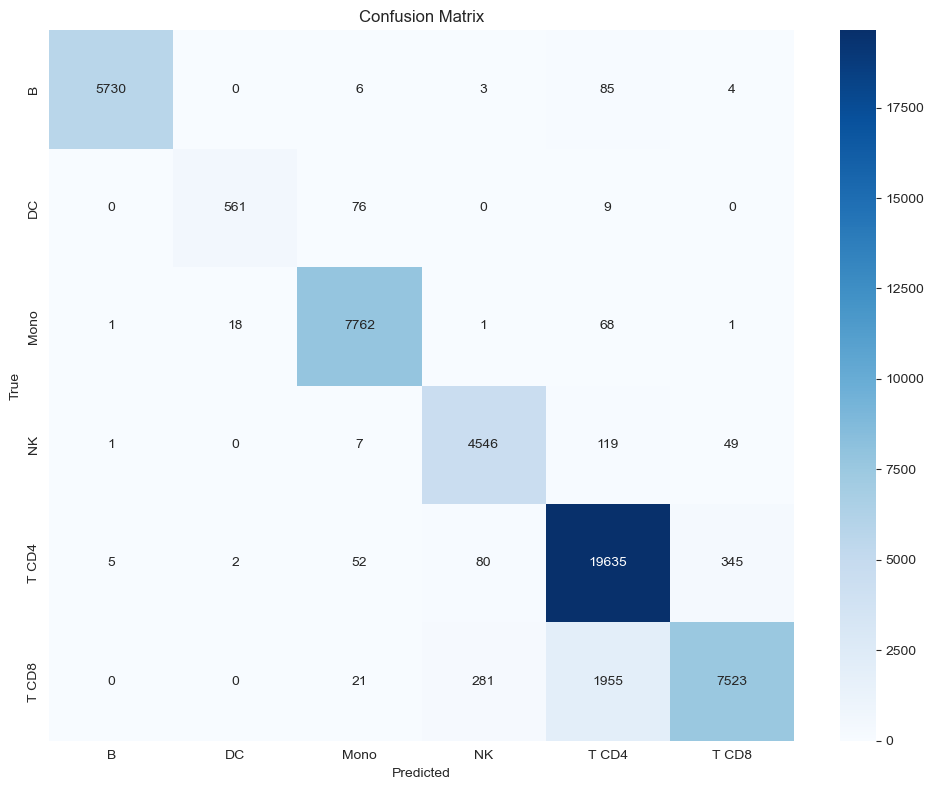

In [6]:
# Print stats
print("Tuned Model - Classification Report:")
for k, v in stats.items():
    print(f"{k}: {v}%")

# Plot confusion matrix
tuner.plot_confusion_matrix(cm)

While the overall classification accuracy remains strong, some shifts in misclassification patterns are noticeable. For instance, the CD4 T cell category appears to absorb more misclassified CD8 cells, likely due to changes in feature thresholds post-tuning. Nonetheless, the model maintains strong performance on monocytes, B cells, and NK cells, consistent with the baseline.

# Baseline vs Tuned

In [3]:
# Load training set to get feature names in correct order
hao = pd.read_csv("../data/hao.csv", index_col=0)
expected_features = hao.drop(columns=["label"]).columns

In [4]:
# Load Kotliarov test data (same format as hao.csv)
kotliarov = pd.read_csv("../data/kotliarov.csv", index_col=0)
X_kot = kotliarov.drop(columns=["label"])
y_kot = kotliarov["label"]

# Align Kotliarov features to match training features
X_kot_aligned = X_kot[expected_features]

In [5]:
io = DiskIO("../models")

baseline_model = io.load("RF", "baseline")
tuned_model = io.load("RFTuner", "final")
label_encoder = io.load("label_encoder_hao")

In [6]:
# Get the list of class labels the encoder was originally trained on
known_labels = label_encoder.classes_

# Create a boolean mask to keep only samples with labels the encoder recognizes
# This is necessary to avoid transforming labels that were not seen during training (would raise an error)
valid_mask = y_kot.isin(known_labels)

# Align test features with training feature order and keep only valid rows
# Note: 'expected_features' must match the training set columns exactly
X_kot_aligned = X_kot[valid_mask][expected_features]

# Filter the test labels to include only valid rows (i.e., rows with known labels)
y_kot_filtered = y_kot[valid_mask]

# Transform the filtered string labels into numerical form using the trained encoder
y_kot_encoded = label_encoder.transform(y_kot_filtered)

In [7]:
from MetricsCore import MetricsCalculator

metrics_calculator = MetricsCalculator()

baseline_metrics, baseline_ci, baseline_sem = metrics_calculator.compute_from_model(
    baseline_model, X_kot_aligned, y_kot_encoded, with_ci=True)

tuned_metrics, tuned_ci, tuned_sem = metrics_calculator.compute_from_model(
    tuned_model, X_kot_aligned, y_kot_encoded, with_ci=True)

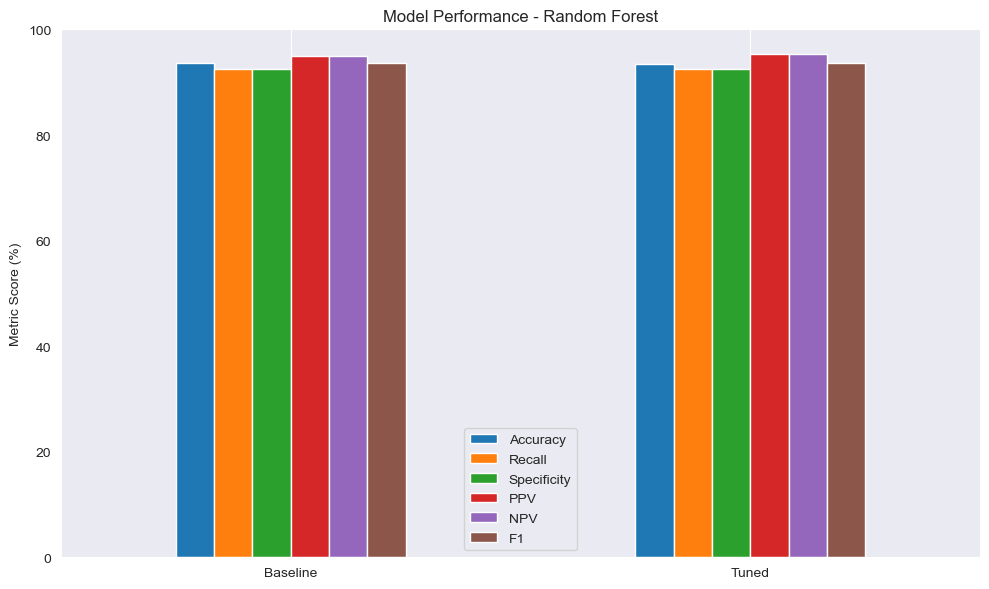

In [11]:
df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Tuned': tuned_metrics
})

df.T.plot(kind='bar', figsize=(10, 6), rot=0)
plt.ylabel("Metric Score (%)")
plt.title("Model Performance - Random Forest")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

This side-by-side bar chart compares the baseline and tuned Random Forest models across six core metrics. While the tuned model achieves slightly higher PPV and NPV, the differences are minimal. Other metrics like accuracy, recall, and F1 score remain very close, confirming that tuning leads to marginal refinements rather than significant performance shifts.

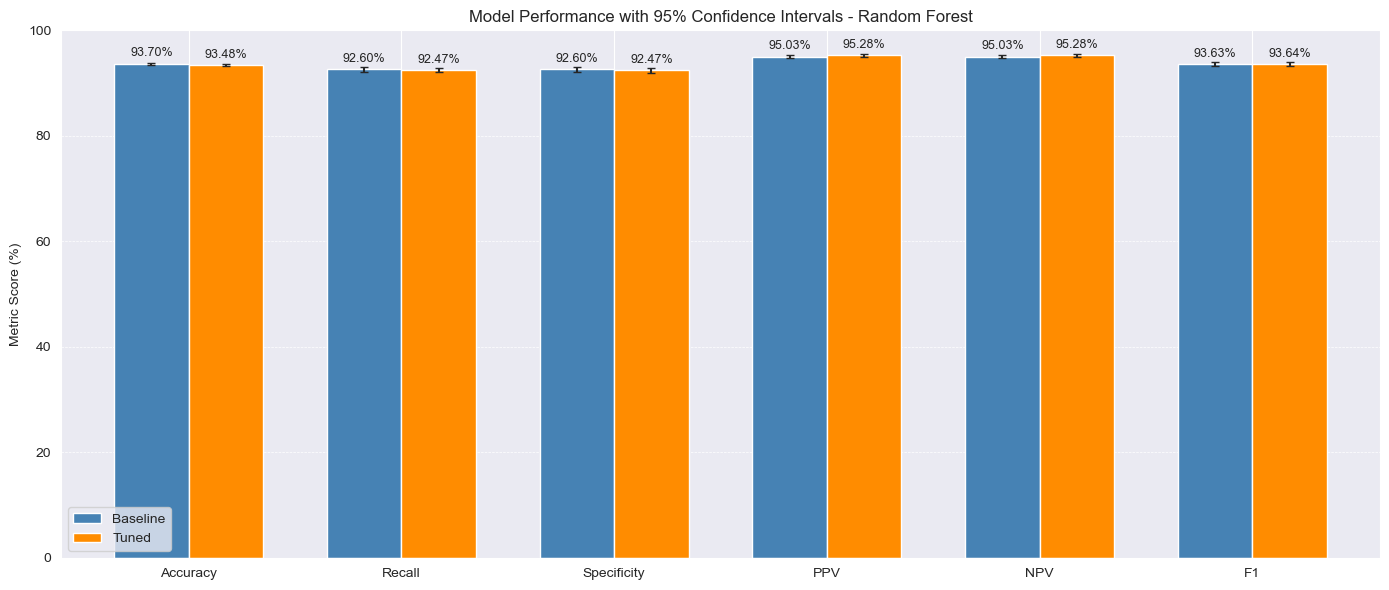

In [9]:
metrics = df.index.tolist()

# Prepare yerr correctly: shape (2, 2, 6)
baseline_yerr = np.array([baseline_ci[m] for m in metrics]).T  # shape: (2, 6)
tuned_yerr = np.array([tuned_ci[m] for m in metrics]).T        # shape: (2, 6)
yerr = np.stack([baseline_yerr, tuned_yerr])                   # shape: (2, 2, 6)

# Plot
ax = df.plot(
    kind='bar',
    figsize=(14, 6),
    rot=0,
    yerr=yerr,
    capsize=3,
    color=['steelblue', 'darkorange'],
    legend=True,
    width=0.7
)

# Add bar labels safely
for container in ax.containers:
    for bar in container:
        if bar is None or not hasattr(bar, 'get_height'):
            continue  # Skip anything invalid
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Final styling
plt.ylabel("Metric Score (%)")
plt.title("Model Performance with 95% Confidence Intervals - Random Forest")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

This bar chart adds 95% confidence intervals (CI) to each performance metric for both models. The overlapping CIs confirm that observed differences are not statistically significant. This reinforces the conclusion that the baseline model was already well-optimized and that tuning primarily helped fine-tune precision without altering overall behavior.

In [12]:
# Prepare list of metrics in desired order
metrics = list(baseline_metrics.keys())

# Construct the table
rows = []
for m in metrics:
    baseline_val = baseline_metrics[m]
    tuned_val = tuned_metrics[m]
    baseline_err = baseline_sem[m]
    tuned_err = tuned_sem[m]
    baseline_interval = (baseline_val - baseline_ci[m][0], baseline_ci[m][1] - baseline_val)
    tuned_interval = (tuned_val - tuned_ci[m][0], tuned_ci[m][1] - tuned_val)

    row = {
        "Metric": m,
        "Baseline": f"{baseline_val:.2f} ± {baseline_err:.2f}",
        "Baseline CI": f"[{baseline_val - baseline_interval[0]:.2f}, {baseline_val + baseline_interval[1]:.2f}]",
        "Tuned": f"{tuned_val:.2f} ± {tuned_err:.2f}",
        "Tuned CI": f"[{tuned_val - tuned_interval[0]:.2f}, {tuned_val + tuned_interval[1]:.2f}]"
    }
    rows.append(row)

# Convert to DataFrame
comparison_table = pd.DataFrame(rows)

# Optional: Set display format for Jupyter or export
pd.set_option("display.colheader_justify", "center")
print("\nModel Performance Comparison with Confidence Intervals\n" + "="*70)
print(comparison_table.to_markdown(index=True))


Model Performance Comparison with Confidence Intervals
|    | Metric      | Baseline     | Baseline CI   | Tuned        | Tuned CI     |
|---:|:------------|:-------------|:--------------|:-------------|:-------------|
|  0 | Accuracy    | 93.70 ± 0.11 | [0.22, 0.20]  | 93.48 ± 0.11 | [0.22, 0.21] |
|  1 | Recall      | 92.60 ± 0.25 | [0.48, 0.47]  | 92.47 ± 0.24 | [0.46, 0.47] |
|  2 | Specificity | 92.60 ± 0.25 | [0.50, 0.52]  | 92.47 ± 0.25 | [0.49, 0.47] |
|  3 | PPV         | 95.03 ± 0.16 | [0.31, 0.32]  | 95.28 ± 0.15 | [0.27, 0.30] |
|  4 | NPV         | 95.03 ± 0.17 | [0.31, 0.32]  | 95.28 ± 0.16 | [0.30, 0.32] |
|  5 | F1          | 93.63 ± 0.18 | [0.35, 0.34]  | 93.64 ± 0.17 | [0.32, 0.32] |


In [10]:
# Create a DataFrame with SEMs
sem_df = pd.DataFrame({
    "Metric": baseline_sem.keys(),
    "Baseline SEM": baseline_sem.values(),
    "Tuned SEM": [tuned_sem[m] for m in baseline_sem.keys()]
})

sem_df.set_index("Metric", inplace=True)
print(sem_df.round(2))  # optionally round for display

             Baseline SEM  Tuned SEM
Metric                              
Accuracy         0.11        0.11   
Recall           0.25        0.24   
Specificity      0.25        0.25   
PPV              0.16        0.15   
NPV              0.17        0.16   
F1               0.18        0.17   


In [11]:
df

,Baseline,Tuned
Accuracy,93.70,93.48
Recall,92.60,92.47
Specificity,92.60,92.47
PPV,95.03,95.28
NPV,95.03,95.28
F1,93.63,93.64


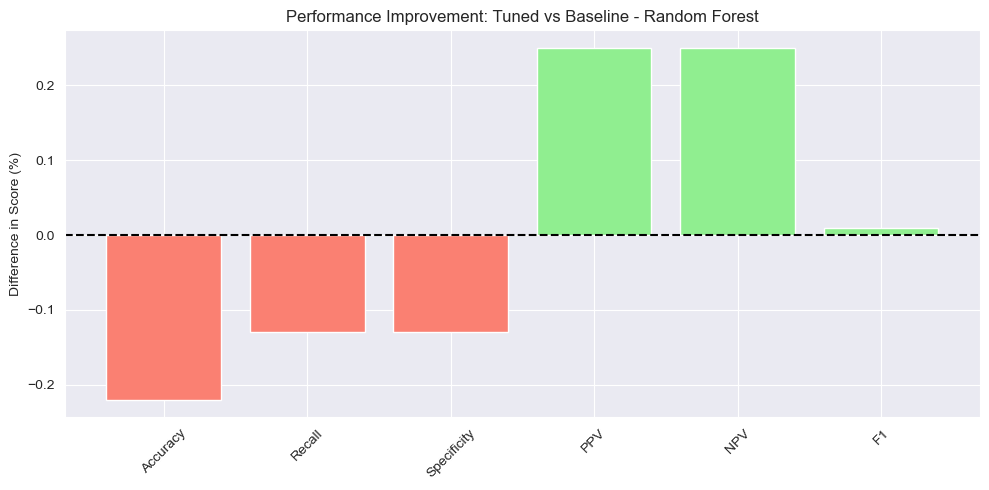

In [10]:
metrics = list(baseline_metrics.keys())
baseline_values = [baseline_metrics[m] for m in metrics]
tuned_values = [tuned_metrics[m] for m in metrics]
diff = [t - b for t, b in zip(tuned_values, baseline_values)]

# Extract the list of metric names from the baseline results (e.g., Accuracy, F1, etc.)
metrics = list(baseline_metrics.keys())

# Collect metric values for baseline and tuned models in the same order
baseline_values = [baseline_metrics[m] for m in metrics]
tuned_values = [tuned_metrics[m] for m in metrics]

# Compute the difference in performance for each metric (Tuned - Baseline)
# This helps identify which metrics improved and by how much
diff = [t - b for t, b in zip(tuned_values, baseline_values)]

colors = ['lightgreen' if d > 0 else 'salmon' for d in diff]

plt.figure(figsize=(10, 5))
bars = plt.bar(metrics, diff, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.title("Performance Improvement: Tuned vs Baseline - Random Forest")
plt.ylabel("Difference in Score (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This plot visualizes the delta between tuned and baseline scores across metrics. Gains in PPV and NPV are clearly visible, while small drops are seen in accuracy, recall, and specificity. The F1 score remains effectively unchanged. This confirms that tuning helped slightly improve precision but at a minor trade-off with sensitivity. The color-coded bars (green for improvement, red for decline) offer a quick visual summary of where tuning helped or had limited benefit.

In [10]:
# Predict labels on the Kotliarov test set using both baseline and tuned models
baseline_preds = baseline_model.predict(X_kot_aligned)
tuned_preds = tuned_model.predict(X_kot_aligned)

# Calculate the percentage of samples for which both models made the same prediction
agreement = np.mean(baseline_preds == tuned_preds)

# Display model agreement in percentage format
print(f"The two models agree on {agreement * 100:.2f}% of predictions.")

The two models agree on 98.77% of predictions.
